# Investigating Snowfall and its Relation to Droughts

# Notebook to demonstrate the correlation between wintertime snowfall and summertime droughts in Colorado


@author = Andrew Fleming for ESCI 7/896.02  
@date = 2023-03-29  
@license = MIT -- https://opensource.org/licenses/MIT


In regions located aroiund the Rocky mountains snowfall plays a major role in the hydrologic cycle.These regions also have trouble in the summertime with water supply and often times they expereinec droughts.

This study will forcus around investigating whether or not there is a correlation between snowfall quantity and drought intesity/frequency.

Many parts of the U.S. rely on snowmelt for water resoruces. Snowmelt from the Rocky mountains often makes its way to the Colorado River or another major aqauduct, so understanding how much and when snow melts off can predict when droughst are likely to occur.


In [10]:
#Import Libraies
import os
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np


Load in Snowfall data from 1997-2022

Data is given in precipitation and in SWE(snow water equivalent) both of which are converted to centimeters

In [11]:
#Specify folder name and variable names
subfolder1_name = 'Snow data'

#%% Load snow data

#Specify folder name and variable names
subfolder1_name = 'Snow data'

#Create function
def readscan(filename):
    #read files
    data_snow = pd.read_csv(filename, header = 1, na_values = [-99.9], 
                   parse_dates=['Date'], index_col='Date')
    #Rename columns
    data_snow = data_snow.rename(columns={'WTEQ.I-1 (in) ': 'SWE_in','PREC.I-1 (in) ': 'Precip_in'})
       
    #Only have integrated data_snow so take difference for daily values
    data_snow['Precip_in']=data_snow['Precip_in'].diff()
    data_snow['SWE_in']=data_snow['SWE_in'].diff()
    
    #resample
    data_snow = data_snow.resample('D').mean(numeric_only=True)
   
    #Convert to cm 
    data_snow['Precip_cm'] = data_snow['Precip_in']*2.54
    data_snow['SWE_cm'] = data_snow['SWE_in']*2.54
   
    #replace negaive values with nan
    data_snow.loc[data_snow['Precip_cm']<0,'Precip_cm'] = np.nan
    data_snow.loc[data_snow['SWE_cm']<0,'SWE_cm'] = np.nan
    
    #Deleat unwanted columns
    data_snow = data_snow[['SWE_cm','Precip_cm']]
    return data_snow

filenames = os.listdir(subfolder1_name)
if 'data_snow' in globals():
    del data_snow
    
for filename in filenames:
    data_snow_small=readscan(subfolder1_name+ '\\' + filename)
    try:
        data_snow= pd.concat([data_snow,data_snow_small])
    except:
        data_snow= data_snow_small

# Make non-winter months NaN        
data_snow.loc[~((data_snow.index.month >= 12) | (data_snow.index.month <= 3))] = pd.NA
data_snow = data_snow.dropna()

#Remove decemeber 1996
data_snow = data_snow['1997-01-01':'2022-12-31']

Load in Soil Moisture data from 1997-2022

In [12]:
#%% Load soil moisture data

#Specify folder name and variable names
subfolder2_name = 'Soil data'

#Create function
def readscan(filename):
    #read files
    data_sm = pd.read_csv(filename, header = 1, na_values = [-99.9], 
                   parse_dates=['Date'], index_col='Date')
    #Rename columns
    data_sm = data_sm.rename(columns={'SMS.I-1:-2 (pct)  (loam)': 'SM5',
                                'SMS.I-1:-4 (pct)  (loam)': 'SM10','SMS.I-1:-8 (pct)  (loam)': 'SM20',
                                'SMS.I-1:-20 (pct)  (loam)': 'SM50','SMS.I-1:-40 (pct)  (loam)': 'SM100'})
    
    #Replace negatives with nan
    data_sm.loc[data_sm['SM50']<0,'SM50'] = np.nan
    data_sm.loc[data_sm['SM100']<0,'SM100'] = np.nan
    
    #resample
    data_sm = data_sm.resample('D').mean(numeric_only=True)

    data_sm = data_sm[['SM5','SM10','SM20','SM50','SM100']]
    return data_sm

filenames = os.listdir(subfolder2_name)

for filename in filenames:
    data_sm_small=readscan(subfolder2_name+ '\\' + filename)
    try:
        data_sm= pd.concat([data_sm,data_sm_small])
    except:
        data_sm= data_sm_small

#Fill in Missing data
data_sm['SM5'] = data_sm['SM5'].fillna(data_sm['SM10'])
data_sm['SM10'] = data_sm['SM10'].fillna((data_sm['SM5'] +data_sm['SM20'])/2)
data_sm['SM20'] = data_sm['SM20'].fillna((data_sm['SM10'] +data_sm['SM50'])/2)
data_sm['SM50'] = data_sm['SM50'].fillna((data_sm['SM20'] +data_sm['SM100'])/2)
data_sm['SM100'] = data_sm['SM100'].fillna(data_sm['SM50'])

#Integrating  data       
data_sm['tot_soilmoisture'] = np.trapz(data_sm[['SM5', 'SM10', 'SM20', 'SM50', 'SM100']])

#Isolate SM to summer months
data_sm.loc[~((data_sm.index.month >= 6) | (data_sm.index.month <= 9))] = pd.NA
data_sm = data_sm.dropna()


Create an data frame containing values describing annual acculumation of SWE

In [13]:
#%% Creating annual data frame for SWE
    
#Counting Number of non-null values
nonnan_count = data_snow.notnull().groupby(data_snow.index.year).sum()

#Create new data frame
dfscan_fill1 = data_snow.interpolate()

#Calculate values
dfannual_swe = dfscan_fill1[['SWE_cm']].groupby(data_snow.index.year).sum()

Creating a data frame containing average annual soil moistue values for the desired study period. This is the
annual average total soil moisture for the months of June, July, August, and September.

In [16]:
#%% Annual data frame for SM

#Counting Number of non-null values
nonnan_count = data_sm.notnull().groupby(data_sm.index.year).mean()

#Create new data frame
dfscan_fill2 = data_sm.interpolate()

#Calculate values
dfannual_sm = dfscan_fill2[['tot_soilmoisture']].groupby(data_sm.index.year).mean()

#Rename column
dfannual_sm = dfannual_sm.rename(columns={'tot_soilmoisture': 'avg_soilmoisture'})
                                       

Creating a time series plot for the snow data over the study period


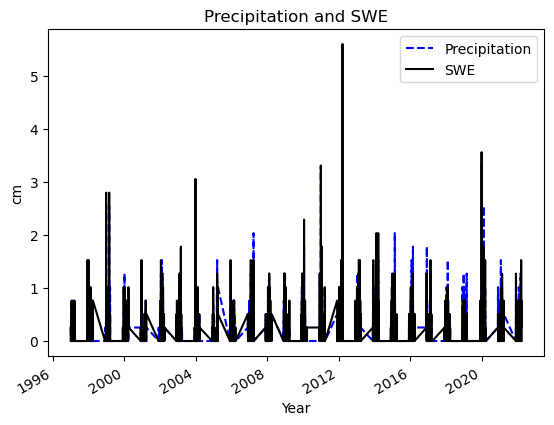

In [17]:
# Create plot 
fig1, ax = plt.subplots()

# Plot another data series
ax.plot(data_snow['Precip_cm'],  # x = 1st series, y = 2nd series)
        'b--',                            # Line Format
        label = 'Precipitation')         # series label for legend

# Plot one data series 
ax.plot(data_snow['SWE_cm'],  # x = 1st series, y = 2nd series)
        'k-',                           # Line Format
        label = 'SWE')       # series label for legend


# Add plot components 
ax.set_xlabel('Year')         # x-axis label 
ax.set_ylabel('cm')          # y-axis label
ax.set_title('Precipitation and SWE') # figure title
ax.legend()                                   # legend

# Optional command to make x-tick labels diagonal to avoid overlap
fig1.autofmt_xdate()  

Create a time series plot for soil moisture data over the desired study period

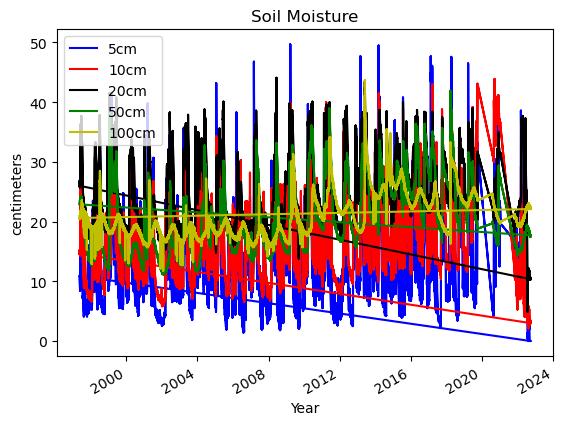

In [18]:
#%%Create Time Series Plot for SM

# Create plot 
fig2, ax2 = plt.subplots()

# Plot another data series
ax2.plot(data_sm['SM5'],  # x = 1st series, y = 2nd series)
        'b',                            # Line Format
        label = '5cm')         # series label for legend

ax2.plot(data_sm['SM10'],  # x = 1st series, y = 2nd series)
        'r',                            # Line Format
        label = '10cm')         # series label for legend

ax2.plot(data_sm['SM20'],  # x = 1st series, y = 2nd series)
        'k',                            # Line Format
        label = '20cm')         # series label for legend

ax2.plot(data_sm['SM50'],  # x = 1st series, y = 2nd series)
        'g',                            # Line Format
        label = '50cm')         # series label for legend

ax2.plot(data_sm['SM100'],  # x = 1st series, y = 2nd series)
        'y',                            # Line Format
        label = '100cm')         # series label for legend


# Add plot components 
ax2.set_xlabel('Year')         # x-axis label 
ax2.set_ylabel('centimeters')          # y-axis label
ax2.set_title('Soil Moisture') # figure title
ax2.legend()                                   # legend

# Optional command to make x-tick labels diagonal to avoid overlap
fig2.autofmt_xdate() 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


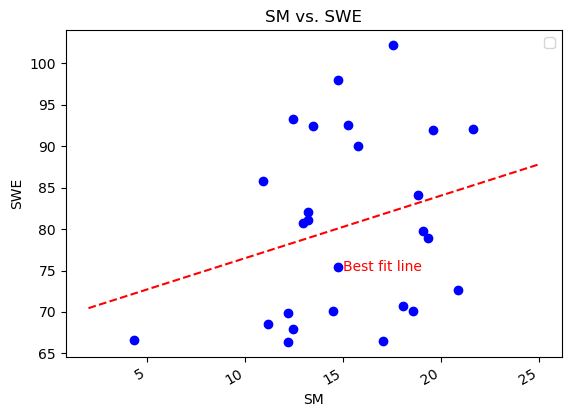

In [19]:
#%%Plot SM vs SWE
# Create plot 
fig3, ax3 = plt.subplots()

# Plot another data series
ax3.plot(dfannual_swe['SWE_cm'], dfannual_sm['avg_soilmoisture'],  # x = 1st series, y = 2nd series)
        'bo')                           # Line Format
             
#Best fit equation
slope,intercept = np.polyfit(dfannual_swe['SWE_cm'], 
                             dfannual_sm['avg_soilmoisture'],1)
#Variables for best fit line
m = slope
b = intercept
x1 =  2
x2 =  25
y1 = m*x1 +b
y2 = m*x2 +b

#Plot best fit line
ax3.plot([x1,x2],[y1,y2],'r--') 
ax3.annotate('Best fit line',xy = (15,75),color = 'r')
# Add plot components 
ax3.set_xlabel('SM')         # x-axis label 
ax3.set_ylabel('SWE')          # y-axis label
ax3.set_title('SM vs. SWE') # figure title
ax3.legend()                                   # legend

# Optional command to make x-tick labels diagonal to avoid overlap
fig3.autofmt_xdate() 

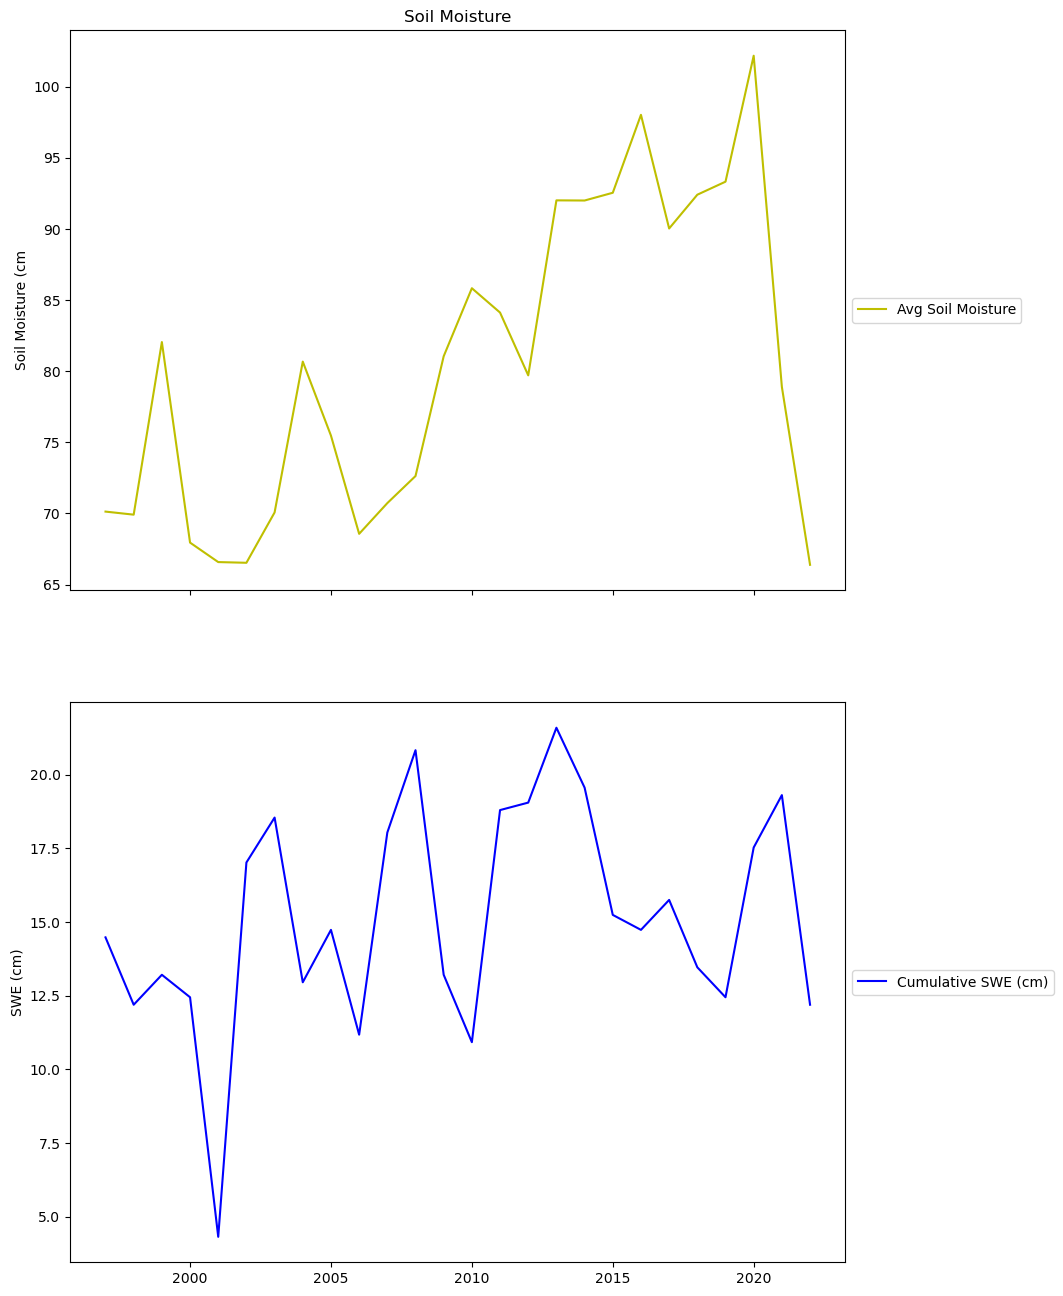

In [20]:
#Figure 1 
fig, (ax1,ax2) = plt.subplots(2,
             1, figsize=(10,16), sharex = True)

# Plot a Soil Moisture
ax1.plot(dfannual_sm.index, dfannual_sm['avg_soilmoisture'], color = 'y',
             label = 'Avg Soil Moisture') 
          
ax1.legend(loc='center left',bbox_to_anchor= (1.0, 0.5))
    
# Add y-axis label    
ax1.set_ylabel('Soil Moisture (cm')   
    
# Add plot title
ax1.set_title('Soil Moisture')
    
# Plot b SWE
ax2.plot(dfannual_swe.index, dfannual_swe['SWE_cm'], color = 'b',
            label = 'Cumulative SWE (cm)')
ax2.set_ylabel('SWE (cm)')
ax2.legend(loc='center left',bbox_to_anchor= (1.0, 0.5))

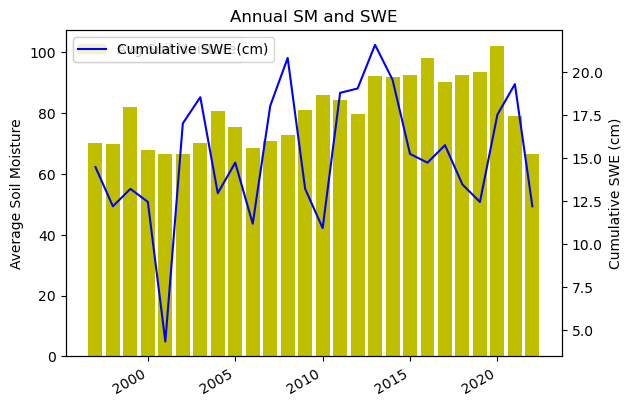

In [21]:
#Figure  
fig4, ax1=plt.subplots()

# Plot a Soil Moisture
plt.bar(dfannual_sm.index, dfannual_sm['avg_soilmoisture'], color = 'y',
             label = 'Avg Soil Moisture') 

ax1.set_ylabel('Average Soil Moisture')

ax2 = ax1.twinx()

# Plot SWE
ax2.plot(dfannual_swe.index, dfannual_swe['SWE_cm'], color = 'b',
            label = 'Cumulative SWE (cm)')

ax2.set_ylabel('Cumulative SWE (cm)')

#Add Legends
ax1.legend()
ax2.legend()

ax1.set_title('Annual SM and SWE') # figure title

fig4.autofmt_xdate() 

In [22]:
Create a linear regression plot for soil moistue versus SWE

SyntaxError: invalid syntax (2141561280.py, line 1)

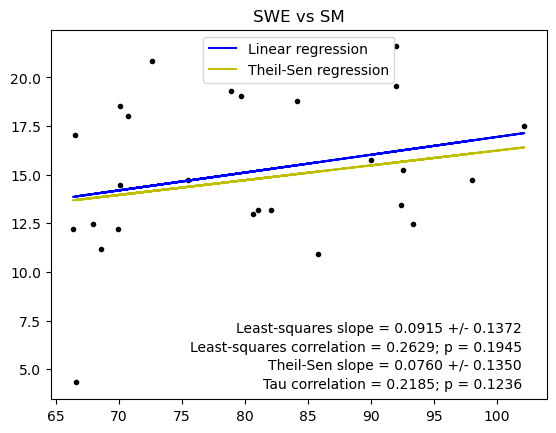

In [23]:

#Create function
def regressplot(data1_series,data2_series, figtitle):

    #Calculate parametric linear regression values
    lsq_coeff = stats.linregress(data1_series,data2_series)
    
    #Calculate non-parametric regression values
    sen_coeff = stats.theilslopes(data2_series,data1_series, 0.95)
    
    #Calculate non-parametric correlation
    tau = stats.kendalltau(data1_series,data2_series)

    #Create plot and show time eries of input data series
    fig, ax = plt.subplots()
    ax.plot(data1_series,data2_series, 'k.')
    #Parametric best fit line
    ax.plot(data1_series, lsq_coeff.intercept + lsq_coeff.slope *
          data1_series, 'b-', label='Linear regression')
    #Annotation Placement
    xx = ax.get_xlim()
    yy = ax.get_ylim()

    #Display least squares sparametric slope and correlation on graph
    ax.annotate(f'Least-squares slope = {lsq_coeff.slope:.4f} +/- {2*lsq_coeff.stderr:.4f}',
                xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.18*(yy[1]-yy[0])),
                horizontalalignment='right')
    ax.annotate(f'Least-squares correlation = {lsq_coeff.rvalue:.4f}; p = {lsq_coeff.pvalue:.4f}',
                xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.13*(yy[1]-yy[0])),
                horizontalalignment='right')

    #Non-parametric best fit line
    ax.plot(data1_series, sen_coeff.intercept + sen_coeff.slope *
               data1_series, 'y-', label='Theil-Sen regression')

    #Display non-parametric slope and correlation on graph
    ax.annotate(f'Theil-Sen slope = {sen_coeff.slope:.4f} +/- {0.5*(sen_coeff.high_slope - sen_coeff.low_slope):.4f}',
                    xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.08*(yy[1]-yy[0])),
                    horizontalalignment='right')
    ax.annotate(f'Tau correlation = {tau.correlation:.4f}; p = {tau.pvalue:.4f}',
                    xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.03*(yy[1]-yy[0])),
                    horizontalalignment='right')

    ax.set_title(figtitle)
    #ax.set_ylabel(y_label)
    ax.legend(loc='upper center')
    plt.show()

regressplot(dfannual_sm['avg_soilmoisture'],dfannual_swe['SWE_cm'], 'SWE vs SM')